# ATSC-411 - SYNOPTIC METEOROLOGY | LAB 4

### QG-Omega: Q-Vectors

----- 

## IMPORT PACKAGES 
Run this cell to import Python code packages that will help us get the data, process the data, conduct math operations, and build some maps.

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import metpy

/research/modules/mpich/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## OPEN ONLINE DATASET
Ignore the warnings :)

In [2]:
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/'
                     'python-gallery/GFS_20101026_1200.nc').metpy.parse_cf()

Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection


## SUBSET DATA
We don't need the entire globe, so we'll limit the data from 10-65 deg N and 20 to 170 deg W.  This will make the data we download much less.

In [3]:
# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(200, 350)
lat_slice = slice(65, 10)

# Grab lat/lon values (GFS will be 1D)
lats = ds.lat.sel(lat=lat_slice).values
lons = ds.lon.sel(lon=lon_slice).values

## GRAB DATA
For this lab, we'll focus on the 750-hPa pressure level.

For thermal advection and Q-vectors, we just need this level.

For differential vorticity advection, we need winds above and below this level.  We'll use 850-hPa and 700-hPa.

In [4]:
# Grab data for thermal advection and Q-vectors
# Smooth data using a nine-point filter applied 10 times to try to isolate synoptic signal
level = 750 * units.hPa
hght_750 = mpcalc.smooth_n_point(ds.Geopotential_height_isobaric.metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze(), 9, 10)
tmpk_750 = mpcalc.smooth_n_point(ds.Temperature_isobaric.metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze(), 9, 10)
uwnd_750 = mpcalc.smooth_n_point(ds['u-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze(), 9, 10)
vwnd_750 = mpcalc.smooth_n_point(ds['v-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze(), 9, 10)

# Grab data for vorticity advection
# Smooth data using a nine-point filter applied 20 times to try to isolate synoptic signal
level = 850 * units.hPa
uwnd_850 = mpcalc.smooth_n_point(ds['u-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze(), 9, 20)
vwnd_850 = mpcalc.smooth_n_point(ds['v-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze(), 9, 20)
level = 700 * units.hPa
uwnd_700 = mpcalc.smooth_n_point(ds['u-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze(), 9, 20)
vwnd_700 = mpcalc.smooth_n_point(ds['v-component_of_wind_isobaric'].metpy.sel(
    vertical=level, lat=lat_slice, lon=lon_slice).squeeze(), 9, 20)

# Calculate grid distances in meters
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Convert time to something that's easy to read
vtime = ds.time.data[0].astype('datetime64[ms]').astype('O')

## TEMPERATURE ADVECTION
Calculate temperature advection using metpy.calc advection function.

In [5]:
tempadv_750 = mpcalc.advection(tmpk_750, u=uwnd_750, v=vwnd_750, dx=dx, dy=dy).metpy.convert_to_base_units()

/research/modules/mpich/miniconda3/lib/python3.9/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(


## PLOT TEMPERATURE ADVECTION

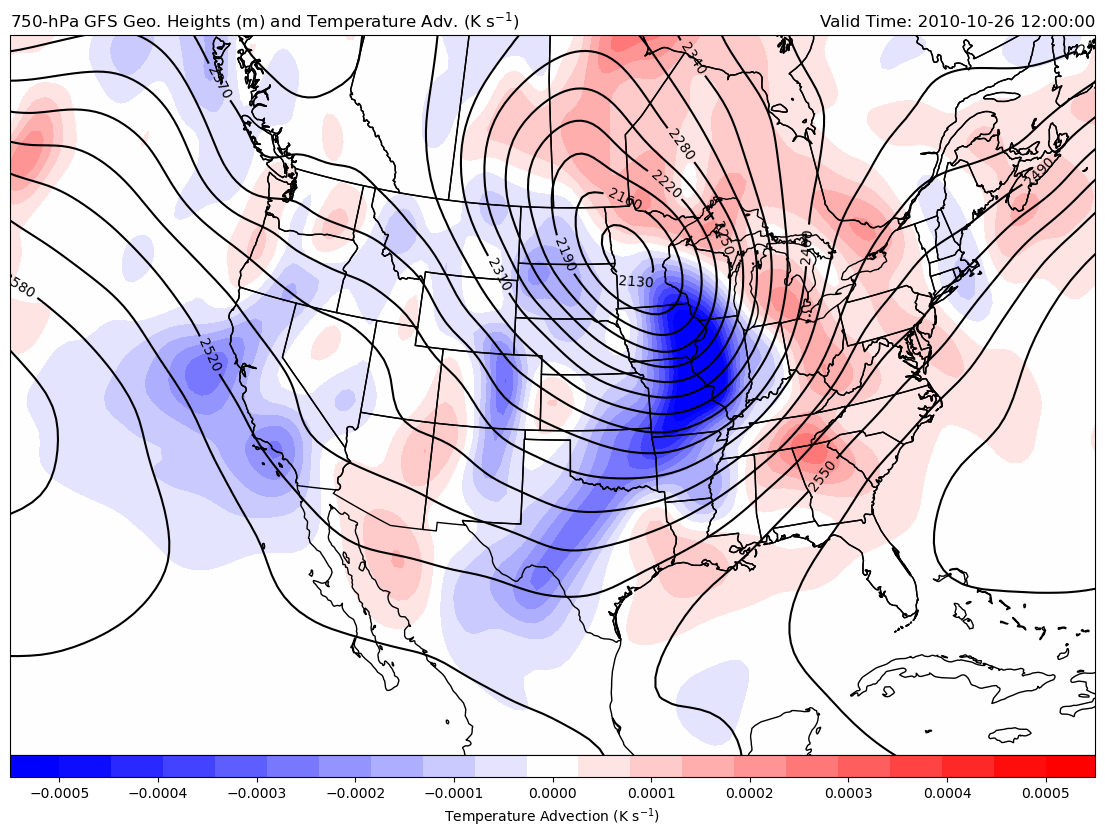

In [6]:
# Set the map projection (how the data will be displayed)
mapcrs = ccrs.LambertConformal(
    central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))

# Set the data project (GFS is lat/lon format)
datacrs = ccrs.PlateCarree()

# Start the figure and set an extent to only display a smaller graphics area
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add map features to plot coastlines and state boundaries
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 750-hPa Thermal Advection and scale
clevs_tmpa = np.linspace(-5,5,20)*1E-4
cf = ax.contourf(lons, lats, tempadv_750.values, clevs_tmpa, cmap=plt.cm.bwr,
                 extend='both', transform=datacrs)
clevs_lab = np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5])*1E-4
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True,ticks=clevs_lab)
cb.set_label('Temperature Advection (K s$^{-1}$)')

# Plot 750-hPa Geopotential Heights
clevs_750_hght = np.arange(0, 8000, 30)
cs = ax.contour(lons, lats, hght_750, clevs_750_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Add some titles
plt.title('750-hPa GFS Geo. Heights (m)'
          ' and Temperature Adv. (K s$^{-1}$)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.show()

## CALCULATE DIFFERENTIAL VORTICITY ADVECTION
Use absolute vorticity from metpy.  
Calculate the vorticity advection.  
Finally, take the vertical derivative and multiply by -1 since pressure decreases in the up-direction.

In [7]:
avor_850 = mpcalc.absolute_vorticity(uwnd_850, vwnd_850, dx, dy, lats)
avor_700 = mpcalc.absolute_vorticity(uwnd_700, vwnd_700, dx, dy, lats)

# Advection of Absolute Vorticity
vortadv_850 = mpcalc.advection(avor_850, u=uwnd_850, v=vwnd_850, dx=dx, dy=dy).metpy.convert_to_base_units()
vortadv_700 = mpcalc.advection(avor_700, u=uwnd_700, v=vwnd_700, dx=dx, dy=dy).metpy.convert_to_base_units()

# Differential Vorticity Advection between two levels
diff_avor = -1*((vortadv_850 - vortadv_700)/(150 * units.hPa)).metpy.convert_to_base_units()

/research/modules/mpich/miniconda3/lib/python3.9/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(
/research/modules/mpich/miniconda3/lib/python3.9/site-packages/metpy/calc/tools.py:1064: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(


## PLOT DIFF VORTICITY ADVECTION

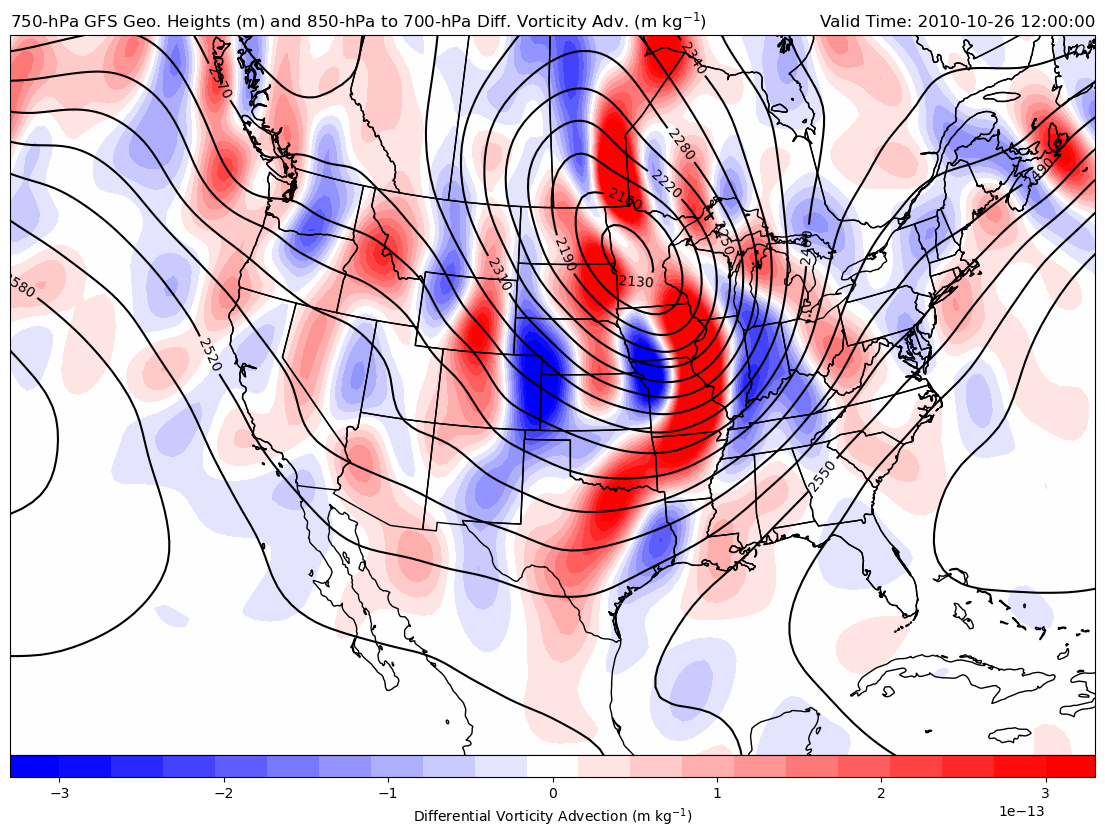

In [13]:
# Set the map projection (how the data will be displayed)
mapcrs = ccrs.LambertConformal(
    central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))

# Set the data project (GFS is lat/lon format)
datacrs = ccrs.PlateCarree()

# Start the figure and set an extent to only display a smaller graphics area
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add map features to plot coastlines and state boundaries
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 850-to-700-hPa Differential Vorticity Advection and scale
clevs_dva = np.linspace(-3,3,20)*1E-13
cf = ax.contourf(lons, lats, diff_avor.values, clevs_dva, cmap=plt.cm.bwr,
                 extend='both', transform=datacrs)
clevs_lab = np.array([-3,-2,-1,0,1,2,3])*1E-13
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True,ticks=clevs_lab)
cb.set_label('Differential Vorticity Advection (m kg$^{-1}$)')

# Plot 750-hPa Geopotential Heights
clevs_750_hght = np.arange(0, 8000, 30)
cs = ax.contour(lons, lats, hght_750, clevs_750_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Add some titles
plt.title('750-hPa GFS Geo. Heights (m)'
          ' and 850-hPa to 700-hPa Diff. Vorticity Adv. (m kg$^{-1}$)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.show()


## CALCULATE Q-VECTORS and Q-VECTOR DIVERGENCE
Multiply by two as QG-Omega has 2*Q-vector

In [10]:
# Compute the Q-vector components
uqvect, vqvect = mpcalc.q_vector(uwnd_750, vwnd_750, tmpk_750, 750*units.hPa, dx, dy)

# Compute the divergence of the Q-vectors calculated above
q_div = 2*mpcalc.divergence(uqvect, vqvect, dx=dx, dy=dy)

## PLOT Q-VECTORS

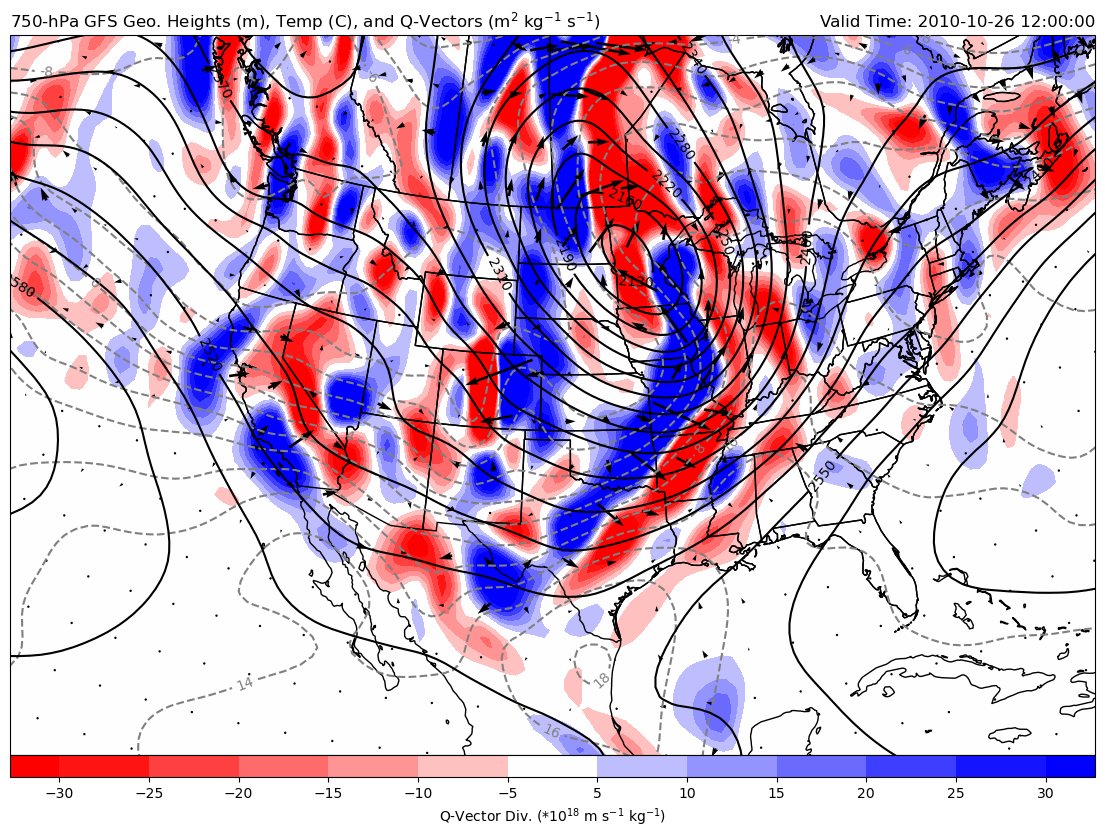

In [12]:
# Set the map projection (how the data will be displayed)
mapcrs = ccrs.LambertConformal(
    central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))

# Set the data project (GFS is lat/lon format)
datacrs = ccrs.PlateCarree()

# Start the figure and set an extent to only display a smaller graphics area
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add map features to plot coastlines and state boundaries
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 750-hPa Q-Vector Divergence and scale
clevs_750_tmpc = np.arange(-40, 41, 2)
clevs_qdiv = list(range(-30, -4, 5))+list(range(5, 31, 5))
cf = ax.contourf(lons, lats, q_div*1e18, clevs_qdiv, cmap=plt.cm.bwr_r,
                 extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True,
                  ticks=clevs_qdiv)
cb.set_label('Q-Vector Div. (*10$^{18}$ m s$^{-1}$ kg$^{-1}$)')

# Plot 750-hPa Temperatures
# Convert temperatures to degree Celsius for plotting purposes
tmpc_750 = tmpk_750.metpy.convert_units('degC')
csf = ax.contour(lons, lats, tmpc_750, clevs_750_tmpc, colors='grey',
                 linestyles='dashed', transform=datacrs)
plt.clabel(csf, fmt='%d')

# Plot 750-hPa Geopotential Heights
clevs_750_hght = np.arange(0, 8000, 30)
cs = ax.contour(lons, lats, hght_750, clevs_750_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 750-hPa Q-vectors, scale to get nice sized arrows
wind_slice = (slice(None, None, 5), slice(None, None, 5))
ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
          uqvect[wind_slice].values,
          vqvect[wind_slice].values,
          pivot='mid', color='black',
          scale=1e-11, scale_units='inches',
          transform=datacrs)

# Add some titles
plt.title('750-hPa GFS Geo. Heights (m), Temp (C),'
          ' and Q-Vectors (m$^2$ kg$^{-1}$ s$^{-1}$)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.show()


## RADAR MOSIAC
Below is the radar mosiac from the same time as the charts you created above.

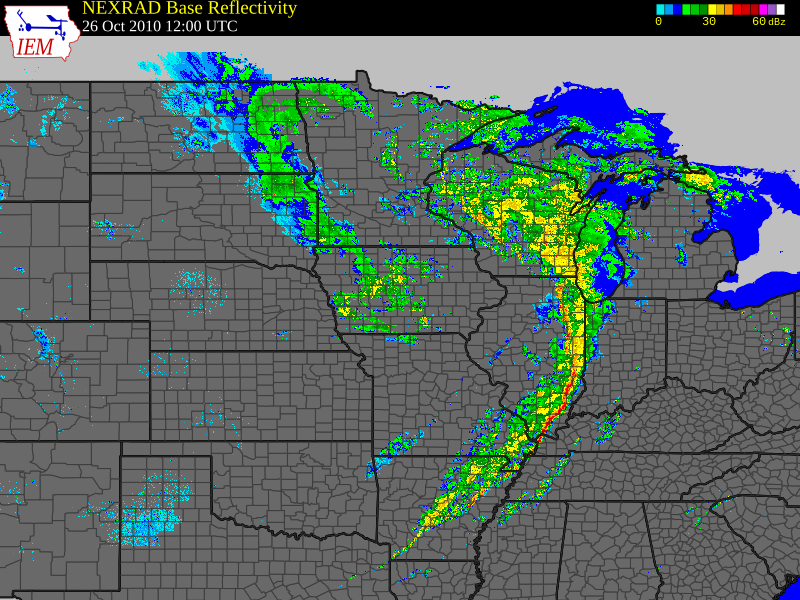